In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
ticker = yf.Ticker('GOOG')
df = ticker.history(start='2016-01-01', end='2025-01-01')
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2016-01-04 00:00:00-05:00,36.974874,37.027622,36.390540,36.917145,65456000,0.0,0.0
1,2016-01-05 00:00:00-05:00,37.146556,37.422748,36.757898,36.953972,39014000,0.0,0.0
2,2016-01-06 00:00:00-05:00,36.327929,37.182880,36.274183,37.005718,38940000,0.0,0.0
3,2016-01-07 00:00:00-05:00,36.343356,36.750926,35.783508,36.148281,59274000,0.0,0.0
4,2016-01-08 00:00:00-05:00,36.400092,36.488674,35.481944,35.555096,49018000,0.0,0.0


In [3]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [4]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2016-01-04,36.974874,37.027622,36.390540,36.917145,65456000,0.0,0.0
1,2016-01-05,37.146556,37.422748,36.757898,36.953972,39014000,0.0,0.0
2,2016-01-06,36.327929,37.182880,36.274183,37.005718,38940000,0.0,0.0
3,2016-01-07,36.343356,36.750926,35.783508,36.148281,59274000,0.0,0.0
4,2016-01-08,36.400092,36.488674,35.481944,35.555096,49018000,0.0,0.0
...,...,...,...,...,...,...,...,...
2259,2024-12-24,195.946768,197.445061,194.975874,197.345184,6809800,0.0,0.0
2260,2024-12-26,196.516126,197.934509,195.647106,196.875717,7907900,0.0,0.0
2261,2024-12-27,196.246426,196.576052,191.753543,193.819183,14693000,0.0,0.0
2262,2024-12-30,190.647813,193.559490,190.143383,192.470734,12209500,0.0,0.0


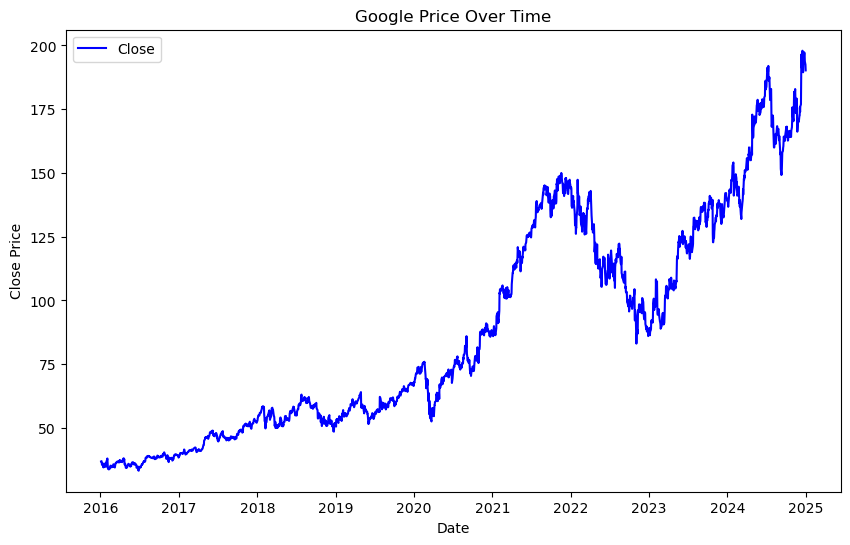

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.title('Google Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show();

In [6]:
# MACD
def compute_macd(data, short=12, long=26, signal=9):
    ema_short = data['Close'].ewm(span=short, adjust=False).mean()
    ema_long = data['Close'].ewm(span=long, adjust=False).mean()

    # MACD line
    macd = ema_short - ema_long

    # Signal line (EMA of MACD)
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    data['MACD'] = macd
    data['Signal'] = signal_line

    return data

df = compute_macd(df)

In [7]:
# RSI
def compute_rsi(data, period=14):
    delta = data['Close'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data

df = compute_rsi(df)

In [8]:
# Bollinger Bands
def compute_bollinger_bands(data, period=20, std_multiplier=2):
    sma = data['Close'].rolling(window=period).mean()
    std = data['Close'].rolling(window=period).std()

    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std

    data['BB_Middle'] = sma
    data['BB_Upper'] = upper_band
    data['BB_Lower'] = lower_band

    return data

df = compute_bollinger_bands(df)

In [9]:
# Moving Average
def compute_ma(data, period=20):
    data[f'SMA_{period}'] = data['Close'].rolling(window=period).mean()
    return data
    
df = compute_ma(df)

In [10]:
df['Lag7'] = df['Close'].shift(7)

In [11]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal,RSI,BB_Middle,BB_Upper,BB_Lower,SMA_20,Lag7
0,2016-01-04,36.974874,37.027622,36.390540,36.917145,65456000,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,37.146556,37.422748,36.757898,36.953972,39014000,0.0,0.0,0.002938,0.000588,100.000000,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,36.327929,37.182880,36.274183,37.005718,38940000,0.0,0.0,0.009334,0.002337,100.000000,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,36.343356,36.750926,35.783508,36.148281,59274000,0.0,0.0,-0.054161,-0.008963,7.797028,NaN,NaN,NaN,NaN,NaN
4,2016-01-08,36.400092,36.488674,35.481944,35.555096,49018000,0.0,0.0,-0.150610,-0.037292,4.491361,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,2024-12-24,195.946768,197.445061,194.975874,197.345184,6809800,0.0,0.0,5.942216,5.089913,68.181513,184.302566,205.960697,162.644434,184.302566,191.162216
2260,2024-12-26,196.516126,197.934509,195.647106,196.875717,7907900,0.0,0.0,5.987217,5.269374,66.683352,185.634717,206.923385,164.346049,185.634717,197.934509
2261,2024-12-27,196.246426,196.576052,191.753543,193.819183,14693000,0.0,0.0,5.710417,5.357583,57.235573,186.804063,207.123919,166.484206,186.804063,196.895676
2262,2024-12-30,190.647813,193.559490,190.143383,192.470734,12209500,0.0,0.0,5.320907,5.350247,53.385334,187.922449,206.781644,169.063253,187.922449,189.933609


In [12]:
df.dropna(inplace=True)
df = df.drop(['Dividends','Stock Splits'],axis=1)

In [13]:
df.shape

(2245, 14)

In [14]:
df = df.reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,MACD,Signal,RSI,BB_Middle,BB_Upper,BB_Lower,SMA_20,Lag7
0,2016-02-01,37.346108,37.714367,36.988306,37.422745,102784000,-0.040885,-0.284573,68.046010,35.838800,37.595523,34.082077,35.838800,35.162952
1,2016-02-02,39.040087,39.307322,38.052265,38.052265,126962000,0.122000,-0.203258,72.504482,35.895556,37.860032,33.931080,35.895556,36.091553
2,2016-02-03,38.329454,38.542442,35.855173,36.176151,123420000,0.098565,-0.142894,48.996209,35.856665,37.762847,33.950483,35.856665,35.415756
3,2016-02-04,35.970133,36.178645,34.927570,35.233624,103374000,0.003894,-0.113536,41.244391,35.768060,37.613117,33.923004,35.768060,35.483932
4,2016-02-05,35.027590,35.033563,33.847181,34.017376,102114000,-0.167345,-0.124298,33.380907,35.661515,37.654313,33.668717,35.661515,34.834507


In [15]:
df = df.set_index('Date')

In [16]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

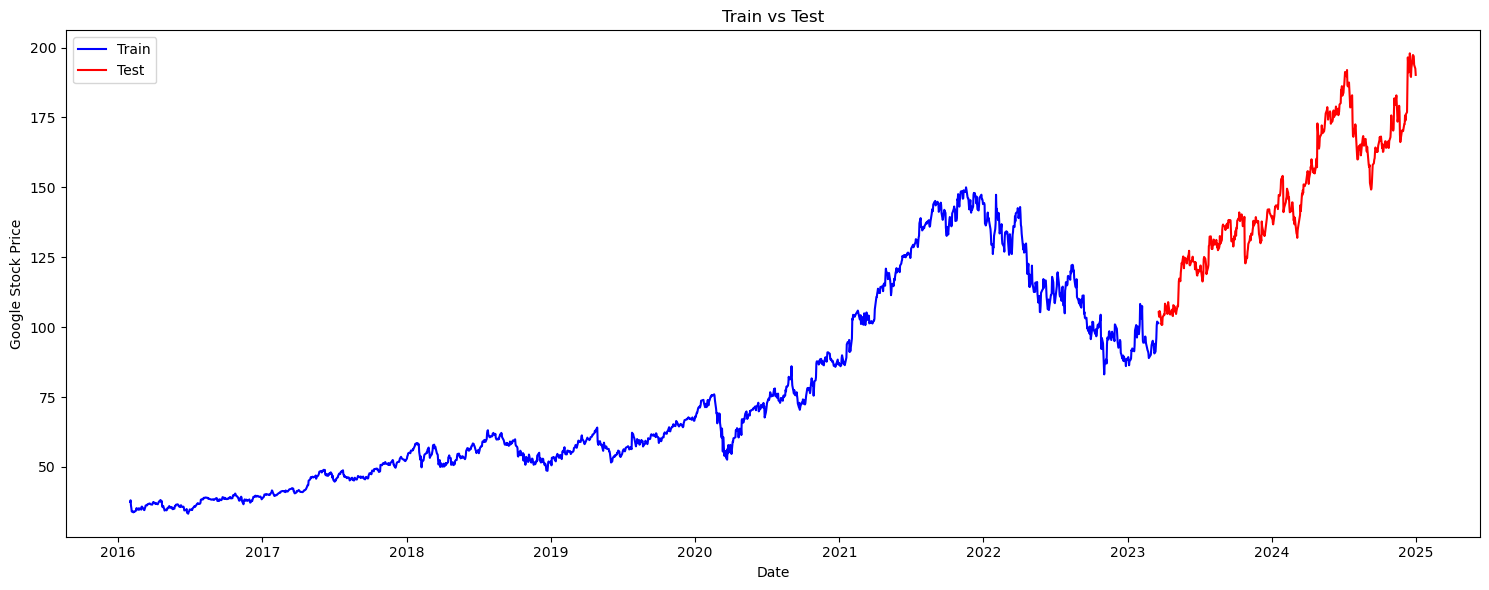

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
# training data
sns.lineplot(x=df.index[:1796], y=df['Close'][:1796], color='blue', label='Train', ax=ax)
# testing data
sns.lineplot(x=df.index[1796:], y=df['Close'][1796:], color='red', label='Test', ax=ax)

ax.set_title('Train vs Test')
ax.set_xlabel('Date')
ax.set_ylabel('Google Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [18]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [19]:
def create_sequence(data, window=3):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:i+window])
        y.append(data[i+window, 3])
    return np.array(x), np.array(y)

In [20]:
x_train, y_train = create_sequence(train_scaled, window=3)
x_test, y_test = create_sequence(test_scaled, window=3)

In [21]:
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)

<h2>Machine Learning</h2>

In [23]:
model = Ridge()
model.fit(x_train_2d, y_train)
y_pred = model.predict(x_test_2d)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared:", r2_score(y_test, y_pred))

MAE: 0.017555561802495765
RMSE: 0.024407630080310192
R-squared: 0.985516180379865


In [24]:
# Number of features
n_features = train_scaled.shape[1]

y_pred_full = np.zeros((len(y_pred), n_features))
y_pred_full[:, 3] = y_pred 

y_pred_original = scaler.inverse_transform(y_pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), n_features))
y_test_full[:, 3] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:, 3]

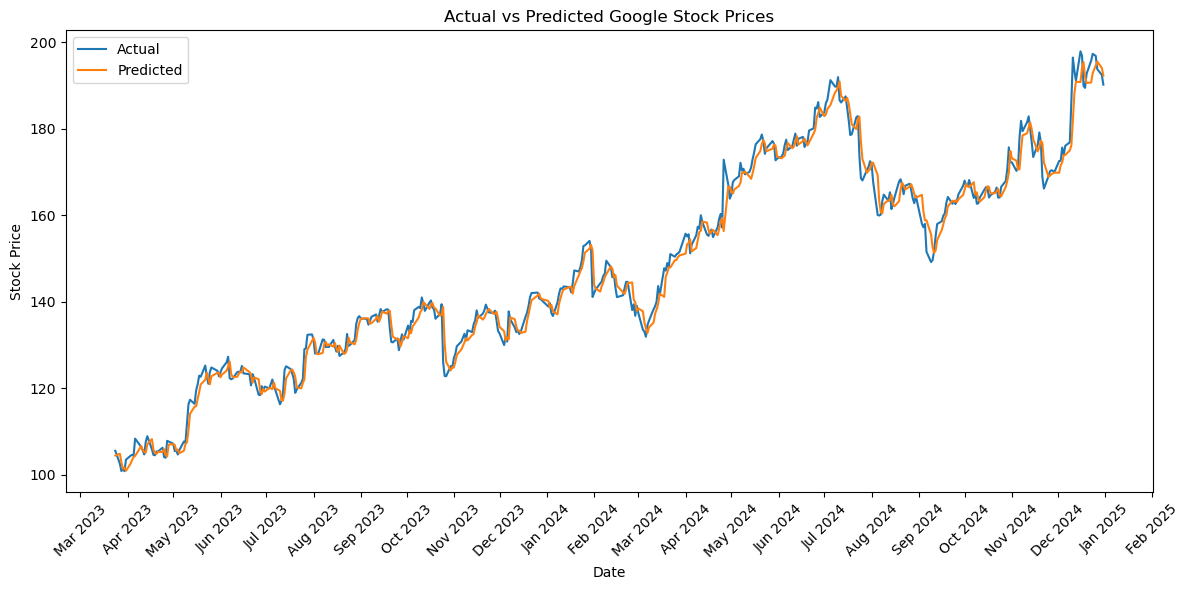

In [25]:
window=3
test_dates = test_df.index[window:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label='Actual')
plt.plot(test_dates, y_pred_original, label='Predicted')

# Format the x-axis to show dates monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Actual vs Predicted Google Stock Prices')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [26]:
results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
}, index=test_dates)

results_df.index.name = 'Date'
results_df

,Actual,Predicted
Date,,
2023-03-24,105.560020,104.469819
2023-03-27,102.574165,104.889981
2023-03-28,100.882179,102.866257
2023-03-29,101.419632,101.432218
2023-03-30,100.842361,101.646823
...,...,...
2024-12-24,197.345184,192.868125
2024-12-26,196.875717,194.710814
2024-12-27,193.819183,195.566283


<h2>Deep Learning</h2>

In [28]:
model = Sequential()
model.add(LSTM(units=80, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=30, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0410 - mae: 0.1145 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0312 - val_loss: 0.0020 - val_mae: 0.0340
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0289 - val_loss: 0.0013 - val_mae: 0.0268
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0247 - val_loss: 0.0016 - val_mae: 0.0333
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0237 - val_loss: 0.0013 - val_mae: 0.0264
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0259 - val_loss: 0.0018 - val_mae: 0.0364
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0239 - val_loss: 0.0061 - val_mae: 0.0731
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 9/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

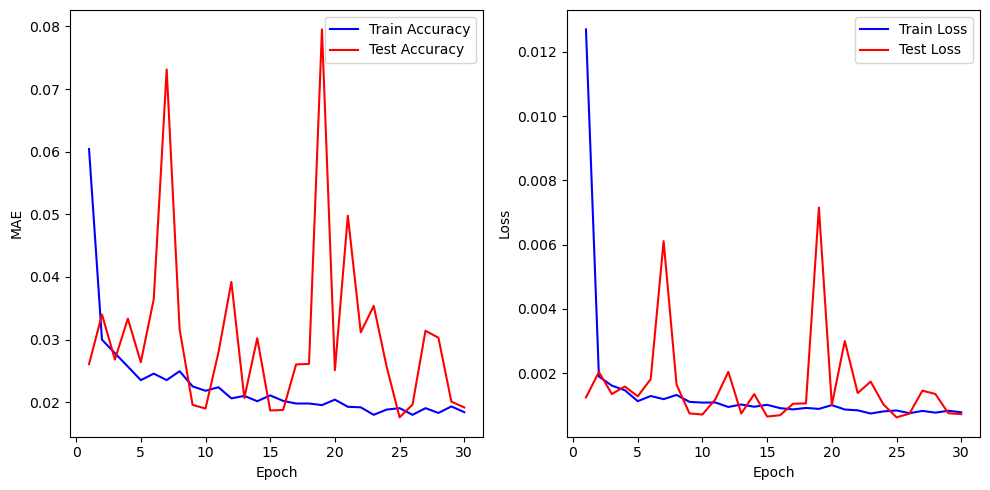

In [29]:
# learning curve
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, mae, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_mae, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# adusting layout for better spacing
plt.tight_layout()
# display the figure
plt.show();

In [30]:
# Predict
y_pred = model.predict(x_test).flatten()

window=3
n_features = train_scaled.shape[1]

y_pred_full = np.zeros((len(y_pred), n_features))
y_pred_full[:, 3] = y_pred
y_pred_original = scaler.inverse_transform(y_pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), n_features))
y_test_full[:, 3] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:, 3]

test_dates = test_df.index[window:]

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [31]:
print("MAE:", mean_absolute_error(y_test_original, y_pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test_original, y_pred_original)))
print("R²:", r2_score(y_test_original, y_pred_original))

MAE: 2.2370741604855695
RMSE: 3.139544841377553
R²: 0.9824165862624974


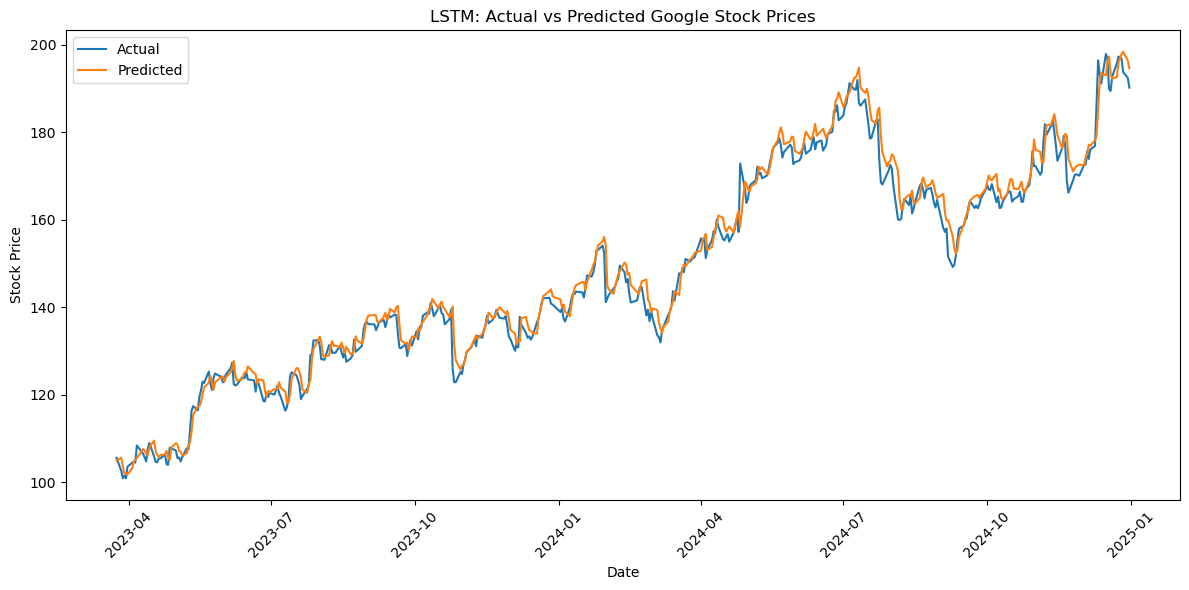

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label='Actual')
plt.plot(test_dates, y_pred_original, label='Predicted')
plt.xticks(rotation=45)
plt.title('LSTM: Actual vs Predicted Google Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [33]:
results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
}, index=test_dates)

results_df.index.name = 'Date'
results_df

,Actual,Predicted
Date,,
2023-03-24,105.560020,104.834601
2023-03-27,102.574165,105.567581
2023-03-28,100.882179,103.662579
2023-03-29,101.419632,101.917134
2023-03-30,100.842361,102.063977
...,...,...
2024-12-24,197.345184,195.881825
2024-12-26,196.875717,197.926837
2024-12-27,193.819183,198.458726
